In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one
def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])        # 80%
Xdev, Ydev = build_dataset(words[n1:n2])    # 10%
Xte, Yte = build_dataset(words[n2:])        # 10%


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),               generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden),   generator=g) * (5/3) / ((n_embd * block_size) ** 0.5)
# b1 = torch.randn(n_hidden,                          generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),            generator=g) * 0.01
b2 = torch.randn(vocab_size,                        generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11697


In [7]:
(torch.randn(10000) * 0.2).std()

tensor(0.2004)

In [8]:
# kaiming init
gain = 5/3
fan_in = n_embd * block_size
gain / (fan_in ** 0.5)

0.3042903097250923

tensor(-0.0007) tensor(0.9964)
tensor(-0.0016) tensor(0.9760)


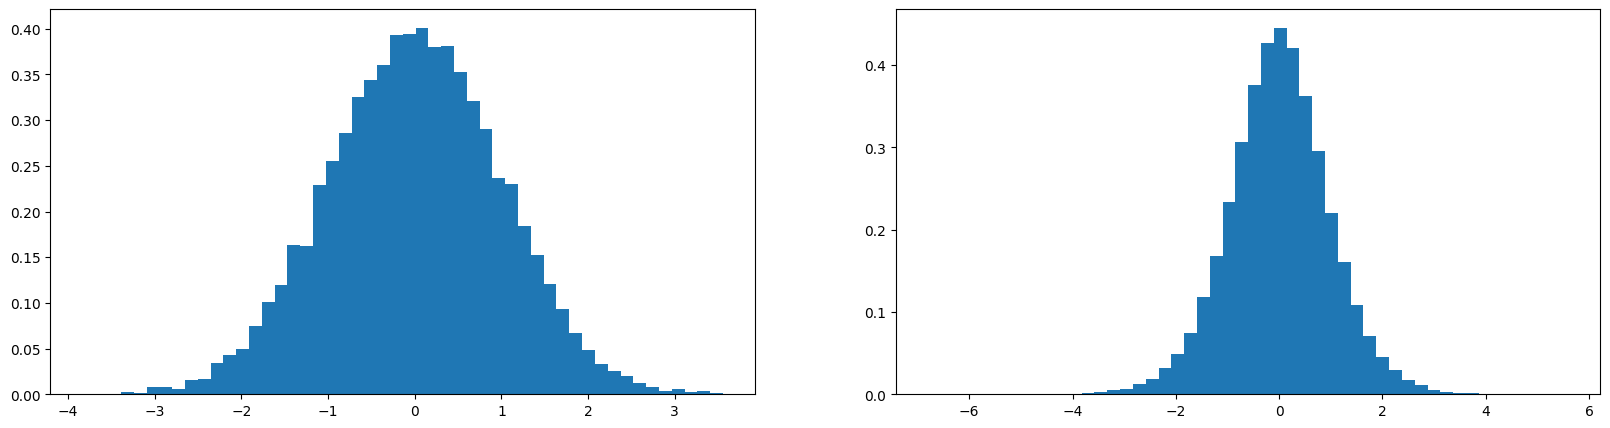

In [9]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

In [259]:
# Let's train a deeper network
class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) #/ fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)                 # batch mean
            xvar = x.var(0, keepdim=True, unbiased=True)    # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
    
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),               generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden),      BatchNorm1d(n_hidden),  Tanh(),
    Linear(             n_hidden, n_hidden),    BatchNorm1d(n_hidden),  Tanh(),
    Linear(             n_hidden, n_hidden),    BatchNorm1d(n_hidden),  Tanh(),
    Linear(             n_hidden, n_hidden),    BatchNorm1d(n_hidden),  Tanh(),
    Linear(             n_hidden, n_hidden),    BatchNorm1d(n_hidden),  Tanh(),
    Linear(             n_hidden, vocab_size),  BatchNorm1d(vocab_size),
]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1
    # layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1.0 # 0.2 # 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

47551


In [278]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain graph
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 1.0 # 0.1 if 1 < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():4,f}')
    lossi.append(loss.log10().item())
    
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
    
    if i >= 1000:
        break # AFTER_DEBUG: would take out obviously to run full optimization
    
    
    

      0/ 200000: 2.734491


layer 2 (      Tanh): mean +0.013605, std 0.64, saturated: 3.47%
layer 5 (      Tanh): mean +0.001665, std 0.63, saturated: 3.38%
layer 8 (      Tanh): mean -0.025434, std 0.64, saturated: 2.59%
layer 11 (      Tanh): mean +0.002943, std 0.65, saturated: 3.09%
layer 14 (      Tanh): mean +0.002670, std 0.64, saturated: 2.91%


Text(0.5, 1.0, 'activation distribution')

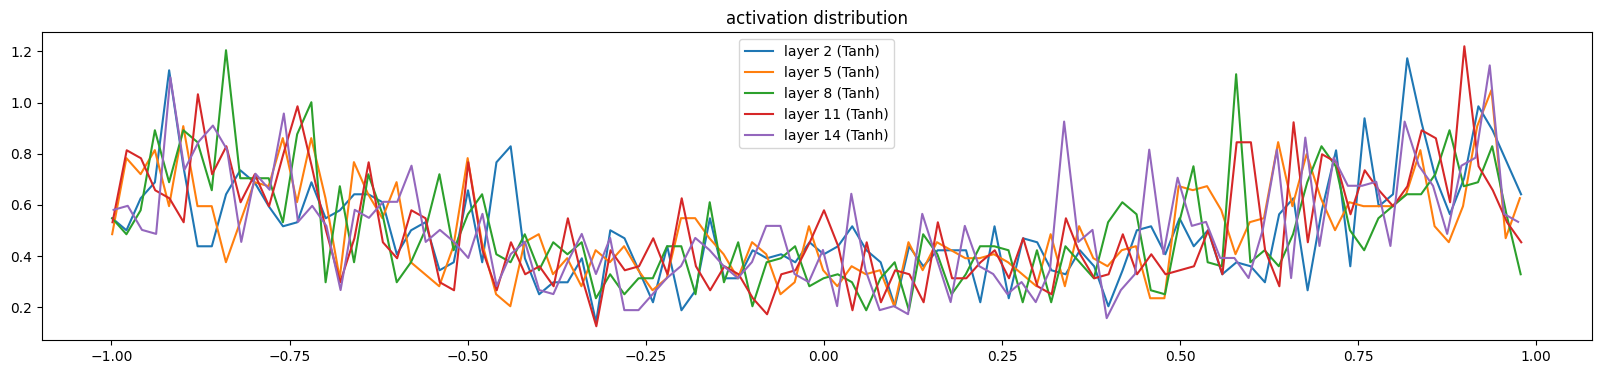

In [279]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean() * 100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 3.994247e-03
layer 5 (      Tanh): mean +0.000000, std 3.516809e-03
layer 8 (      Tanh): mean -0.000000, std 3.502800e-03
layer 11 (      Tanh): mean +0.000000, std 3.350479e-03
layer 14 (      Tanh): mean -0.000000, std 3.614233e-03


Text(0.5, 1.0, 'gradient distribution')

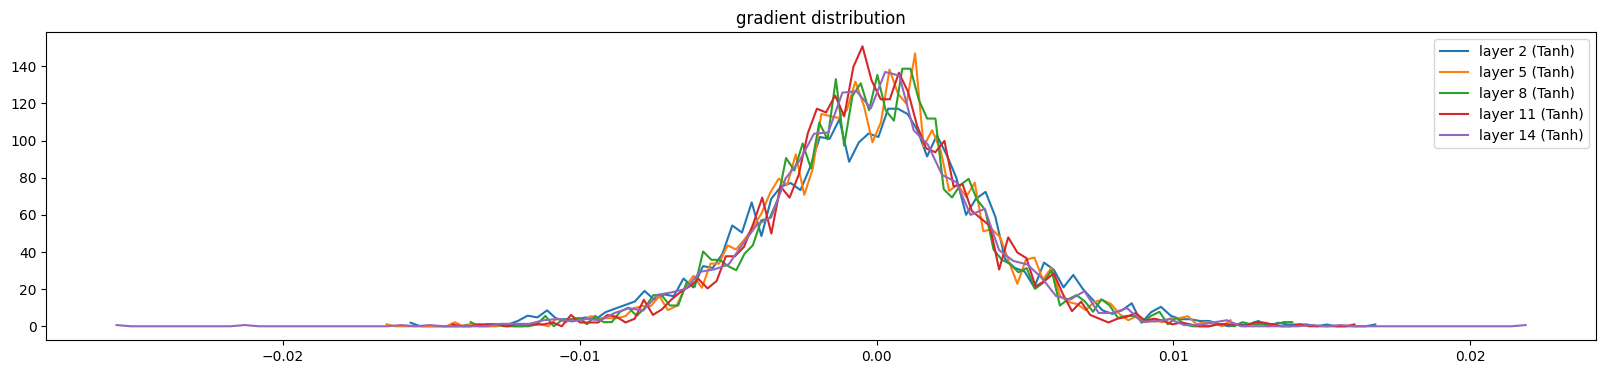

In [280]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000000 | std 9.161811e-03 | grad:data ratio 8.835350e-03
weight  (30, 100) | mean -0.000017 | std 2.530429e-03 | grad:data ratio 2.460691e-03
weight (100, 100) | mean +0.000029 | std 1.252467e-03 | grad:data ratio 1.255479e-03
weight (100, 100) | mean +0.000005 | std 1.157789e-03 | grad:data ratio 1.148593e-03
weight (100, 100) | mean +0.000003 | std 1.138104e-03 | grad:data ratio 1.133892e-03
weight (100, 100) | mean -0.000003 | std 1.091618e-03 | grad:data ratio 1.086599e-03
weight  (100, 27) | mean +0.000002 | std 2.255997e-03 | grad:data ratio 2.277236e-03


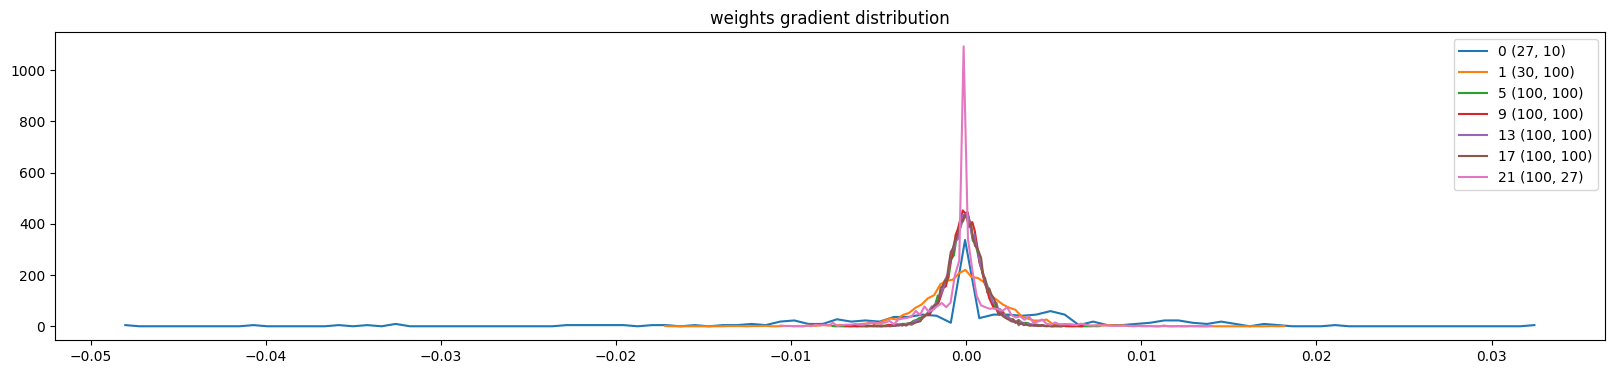

In [281]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
    plt.legend(legends)
    plt.title('weights gradient distribution')

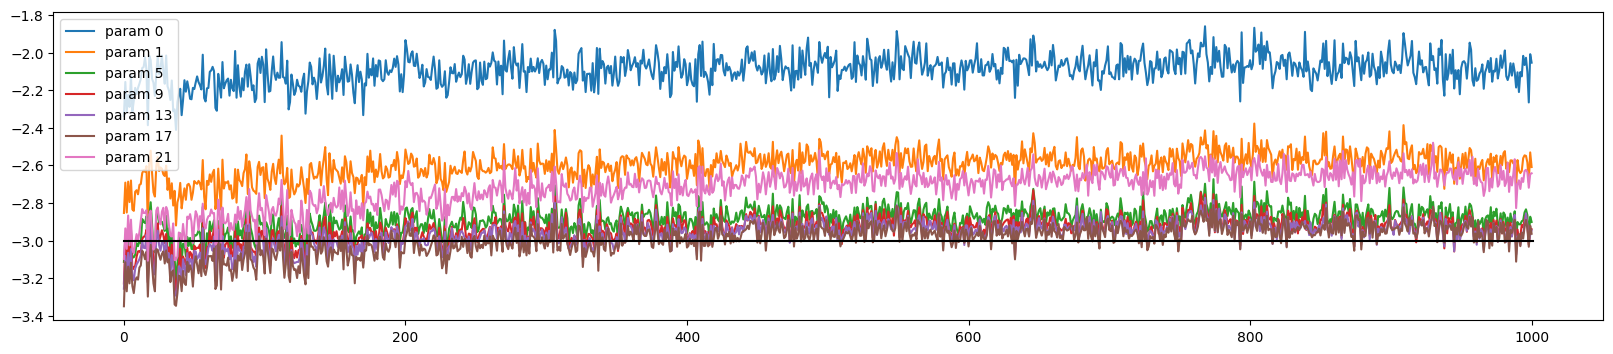

In [282]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3,-3], 'k') # these rations should be ~1e-3, indicate on plot
plt.legend(legends)

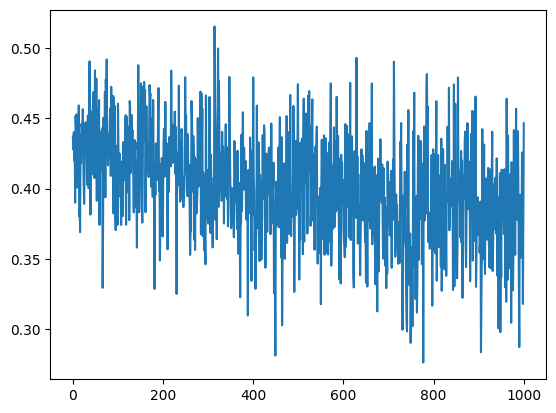

In [283]:
plt.plot(lossi)

In [284]:
# plt.figure(figsize=(20,10))
# plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

In [285]:
# logits[0]

In [286]:
# Initial loss is 27.0, its too high
# Probability to predict next character is 1.0/27 since there are 27 characters
# The negative log of the probability is the loss
-torch.tensor(1/27.0).log()

tensor(3.2958)

In [287]:
# 4-dimensional example of the issue
# logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
# logits = torch.randn(4) * 10
# Essentially, we should keep loss close to zero during initialization
logits = torch.tensor([1.0, 1.0, 1.0, 1.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor(1.3863))

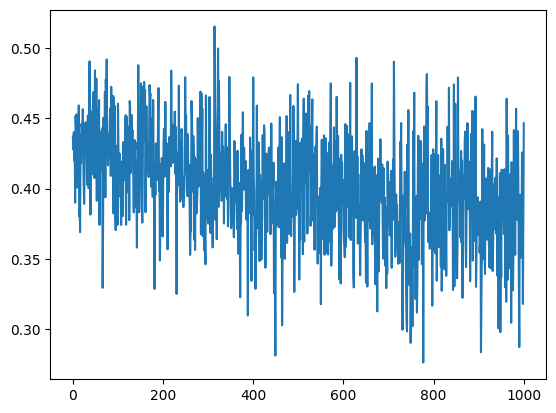

In [288]:
plt.plot(lossi)

In [289]:
# calibrate the batch norm at the end of training

with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [290]:
bnstd

tensor([[2.1568, 1.2029, 1.5549, 1.8884, 2.1565, 2.0077, 1.2650, 1.6386, 1.9261,
         1.3666, 1.7537, 1.9482, 1.4360, 1.6227, 1.0627, 1.4326, 2.2099, 1.3574,
         1.7557, 1.6109, 1.5923, 2.3723, 1.9761, 1.9013, 1.2769, 1.6599, 1.5101,
         1.4733, 2.4120, 1.7004, 1.1376, 1.4682, 2.4228, 1.9086, 2.4982, 1.7803,
         1.6040, 2.5352, 1.8053, 2.3863, 1.7378, 1.6309, 1.6301, 2.1007, 1.3999,
         1.6735, 1.7034, 1.6793, 1.2722, 2.0541, 1.2855, 1.4836, 1.4711, 1.8331,
         2.1927, 2.0132, 1.5191, 1.9933, 3.0362, 1.3920, 1.3213, 1.5692, 1.3690,
         1.8883, 2.2519, 1.9513, 1.5478, 1.6587, 1.9624, 2.1095, 1.5250, 1.7370,
         1.5159, 1.0209, 1.1228, 1.7448, 2.1600, 1.9703, 1.5644, 1.3946, 2.1172,
         1.2898, 1.8024, 2.5645, 2.2296, 1.7608, 1.6436, 1.6289, 2.2641, 1.4306,
         1.7633, 1.9347, 1.9046, 2.4449, 2.3672, 1.4024, 2.1066, 1.7735, 1.3671,
         1.9350, 1.5347, 1.7948, 2.2148, 1.1984, 1.6497, 1.3379, 2.1273, 1.3923,
         1.6223, 2.2345, 1.2

In [291]:
bnstd_running

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.]])

In [292]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 # b1 # hidden layer pre-activation
    # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 3.298614025115967
val 3.2981250286102295


In [293]:
# loss log
# train 2.1245
# val 2.1681

# fix softmax confidently wrong:
# train 2.07
# val 2.13

# fix tanh layer too saturated at init:
# train 2.0355
# val 2.1026

# Using kaiming init:
# train 2.1076157093048096
# val 2.1758861541748047

# add a batch norm layer
# loss log
# train 2.1245
# val 2.1681

# fix softmax confidently wrong:
# train 2.07
# val 2.13

# fix tanh layer too saturated at init:
# train 2.0355
# val 2.1026

# Using kaiming init:
# train 2.1076157093048096
# val 2.1758861541748047

# add a batch norm layer
# train 2.1208620071411133
# val 2.1601927280426025

In [294]:
# sample from the model
g = torch.Generator().manual_seed(2147483647)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])] # initialize with all ...
        h = torch.tanh(emb.view(1, -1) @ W1 ) # + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break
        
    print(''.join(itos[i] for i in out)) # decode and print the generated word

juwjdvdipkcqaz.
p.
cfqywecbwqfjiirltozcogsjgwzvudlgnpauyjbilevhajkdbduinrwibtlzsnjyievyvaftbzffvmumthyfodtumj.
pfytszwjhrjagq.
coreaysezocfkyjjabdywejfmoifmwyfinwagcasnhmvjihouszxhfdgosfmptpagicz.
rjpiufmthdt.
rkyrsru.
iyumfyfy.
mjekujcbkhvupwyhvpvhvccragr.
wdkhwfdztta.
uplypsbxlyhuuiqzavmpocbzthqmimvyqwat.
f.
.
ndxjxfpvslqtikyzsaloevgvvnundewkflbjzqegruxiteaxchwtmuizsodridcdzqojbalgypvrghvxtezrwluciqqvywhqelv.
viosvhibwhnceukgttmwboscnbdoiwupnwnpipkxtpwbgjgyewfdacbfcxrvjypkmsbwanmjrdsydotafvkdkbdeqihzzwzsqdab.
vfuolwbasrtugttbiqbujfdtskceqjtcdlcndfujqllsppgkltwlmlokdmsl.
fddmxjv.
mfsgxmw.
vdihkvngtojvrdsyqivcoi.
uziengogtjvnvqgfjtkqufrxfjljglykiiluohgnoiuqzylq.


In [295]:
# SUMMARY -----------